In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.backends.backend_pdf import PdfPages
import time
import shap
import xgboost as xg
from xgboost import XGBRegressor
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectFromModel,f_regression
from sklearn.feature_selection import VarianceThreshold
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import accuracy_score
from sklearn.metrics import explained_variance_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_absolute_error
from sklearn import model_selection
from sklearn.metrics import r2_score
import scipy.stats as stats
from statistics import stdev
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
#libraires and needed versions
pip freeze

absl-py==0.9.0
alabaster==0.7.12
anaconda-client==1.7.2
anaconda-navigator==1.9.7
anaconda-project==0.8.3
as==0.1
asn1crypto==1.0.1
astor==0.8.1
astroid==2.3.1
astropy==3.2.1
atomicwrites==1.3.0
attrs==19.2.0
Babel==2.7.0
backcall==0.1.0
backports.functools-lru-cache==1.5
backports.os==0.1.1
backports.shutil-get-terminal-size==1.0.0
backports.tempfile==1.0
backports.weakref==1.0.post1
beautifulsoup4==4.8.0
bitarray==1.0.1
bkcharts==0.2
bleach==3.1.0
bokeh==1.3.4
boto==2.49.0
Bottleneck==1.2.1
cachetools==4.0.0
certifi==2019.9.11
cffi==1.12.3
chardet==3.0.4
Click==7.0
cloudpickle==1.2.2
clyent==1.2.2
colorama==0.4.1
comtypes==1.1.7
conda==4.7.12
conda-build==3.18.9
conda-package-handling==1.6.0
conda-verify==3.4.2
contextlib2==0.6.0
cryptography==2.7
cycler==0.10.0
Cython==0.29.13
cytoolz==0.10.0
dask==2.5.2
decorator==4.4.0
defusedxml==0.6.0
distributed==2.5.2
docutils==0.15.2
entrypoints==0.3
et-xmlfile==1.0.1
fastcache==1.1.0
filelock==3.0.12
Flask==1.1.1
fsspec==0.5.2
future==0.17.1

In [3]:
#LOAD AND IMPORT NECESSARY DATA
df_train = pd.read_excel(r'Veri Analitiği_CaseStudy.xlsx',sheet_name=r'interpolated Train data',index_col='Timestamp')
df_test = pd.read_excel(r'Veri Analitiği_CaseStudy.xlsx',sheet_name=r'Test',index_col='Timestamp')

In [4]:
df_train.head()

,Target,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51
Timestamp,,,,,,,,,,,,,,,,,,,,,
2016-08-08 23:00:00,418.953333,329.705162,332.113856,329.498154,-6.011867,-3.599221,-6.031469,6161.653917,6114.724624,6130.824054,...,271.502350,335.773184,336.318695,335.407684,2981.663757,3084.750244,2972.343262,395.356384,395.825043,395.356384
2016-08-08 23:15:00,419.072857,329.817143,332.201617,329.621818,-5.953492,-3.556665,-5.991314,6157.559006,6112.582869,6128.432485,...,271.593947,335.810849,336.352342,335.453468,2981.676204,3081.555568,2971.539978,395.386172,395.844081,395.312968
2016-08-08 23:30:00,419.192381,329.929125,332.289377,329.745481,-5.895118,-3.514109,-5.951158,6153.464096,6110.441115,6126.040916,...,271.685545,335.848514,336.385989,335.499252,2981.688651,3078.360892,2970.736694,395.415960,395.863120,395.269551
2016-08-08 23:45:00,419.311905,330.041106,332.377138,329.869145,-5.836744,-3.471554,-5.911003,6149.369185,6108.299361,6123.649347,...,271.777142,335.886179,336.419635,335.545036,2981.701098,3075.166216,2969.933411,395.445748,395.882159,395.226134
2016-08-09 00:00:00,419.431429,330.153088,332.464899,329.992809,-5.778370,-3.428998,-5.870848,6145.274274,6106.157607,6121.257778,...,271.868740,335.923844,336.453282,335.590820,2981.713545,3071.971540,2969.130127,395.475536,395.901197,395.182717


In [5]:
df_train.describe()

,Target,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51
count,48957.000000,48957.000000,48957.000000,48957.000000,48957.000000,48957.000000,48957.000000,48957.000000,48957.000000,48957.000000,...,48957.000000,48957.000000,48957.000000,48957.000000,48957.000000,48957.000000,48957.000000,48957.000000,48957.000000,48957.000000
mean,418.160363,324.870242,325.686865,324.064356,-5.711331,-4.764521,-6.601196,6604.435434,6635.930930,6566.660155,...,263.012501,333.735576,334.583754,332.986602,2990.154812,3030.368427,2948.133336,380.711865,382.218633,379.285457
std,7.726271,4.618312,4.708470,4.594810,2.635659,2.958228,2.324385,305.240432,305.436885,311.483863,...,6.889097,2.940007,3.026620,2.994239,107.217665,124.831325,127.442129,18.257977,17.671863,18.388616
min,339.700000,302.285765,304.219669,302.016013,-16.607374,-17.162183,-19.822329,5243.379157,5271.925700,5224.489832,...,243.277527,325.117677,325.415405,312.964783,1789.340756,1835.255371,-107.435211,18.154602,24.822950,18.154602
25%,414.566667,321.707407,322.509716,320.991950,-7.252818,-6.682124,-7.855067,6511.447440,6548.268116,6463.324653,...,258.713922,331.576009,332.392592,330.824993,2960.879303,3002.168259,2916.944782,378.656114,380.398842,377.172300
50%,419.000000,325.167299,325.947980,324.339246,-5.666105,-4.754967,-6.433597,6687.105044,6715.982118,6654.421969,...,261.643162,333.622246,334.476700,332.862069,3000.038215,3028.505951,2971.600045,383.917661,385.085241,382.619357
75%,422.100000,328.257635,329.050839,327.422354,-4.112687,-2.723111,-5.295314,6808.150945,6838.615450,6774.251269,...,265.996448,335.988510,336.812612,335.227524,3031.239465,3073.146028,2991.747129,387.476228,388.666139,386.423678
max,622.500000,338.176541,340.516555,334.738352,3.278549,3.486109,3.188496,7062.901989,7318.092695,7071.040128,...,286.102234,345.581729,372.017151,344.279114,3500.841018,6136.091797,3399.188721,407.066589,407.066589,402.814636


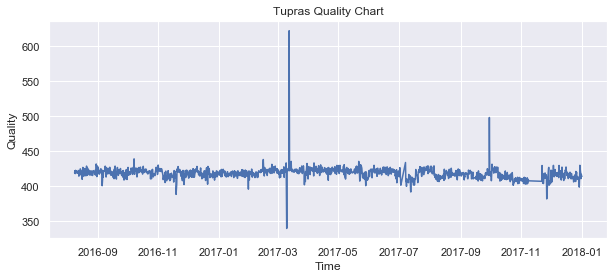

In [6]:
sns.set()
plt.figure(figsize=(10, 4))
plt.title("Tupras Quality Chart")
plt.xlabel("Time")
plt.ylabel("Quality")
plt.plot(df_train["Target"])
plt.show()

In [7]:
non_feature_cols=['Target']
numCols = df_train.drop(non_feature_cols, axis=1).select_dtypes("number").columns
catCols = df_train.drop(non_feature_cols, axis=1).select_dtypes("object").columns
numCols= list(set(numCols))
catCols= list(set(catCols))
print("Kategorik Değişkenler= ", catCols,"Adet :", len(catCols))
print("Adet :",len(numCols),"Numerik Değişkenler= ", numCols)

Kategorik Değişkenler=  [] Adet : 0
Adet : 51 Numerik Değişkenler=  ['V7', 'V13', 'V9', 'V26', 'V33', 'V15', 'V23', 'V31', 'V25', 'V34', 'V41', 'V10', 'V43', 'V51', 'V47', 'V39', 'V27', 'V40', 'V19', 'V17', 'V16', 'V20', 'V1', 'V48', 'V42', 'V21', 'V4', 'V14', 'V50', 'V3', 'V2', 'V35', 'V37', 'V38', 'V44', 'V46', 'V11', 'V18', 'V24', 'V5', 'V12', 'V30', 'V32', 'V45', 'V8', 'V22', 'V29', 'V36', 'V6', 'V28', 'V49']


In [8]:
#Null Check
df_train.isnull().sum()

Target    0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
V29       0
V30       0
V31       0
V32       0
V33       0
V34       0
V35       0
V36       0
V37       0
V38       0
V39       0
V40       0
V41       0
V42       0
V43       0
V44       0
V45       0
V46       0
V47       0
V48       0
V49       0
V50       0
V51       0
dtype: int64

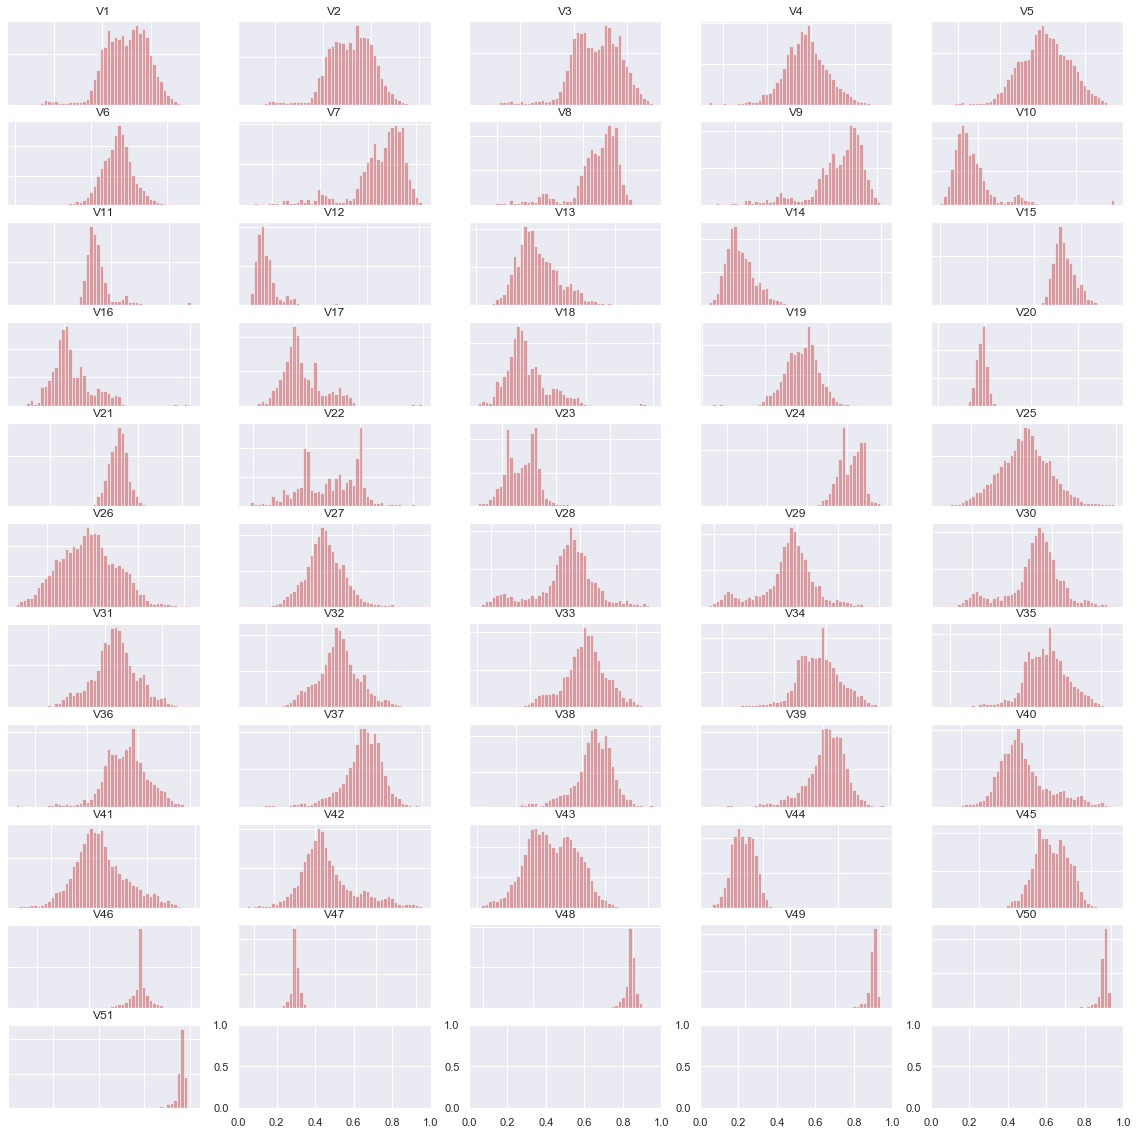

In [9]:
columns = df_train.iloc[:,1:].columns
fig, axes = plt.subplots(nrows=11, ncols=5,figsize=(20,20))
axes = axes.flatten()
for i in range(len(columns)):
    axes[i].hist(df_train[columns[i]], bins=50,facecolor='r',alpha=0.5)
    axes[i].set_title(columns[i])
    plt.setp(axes[i].get_xticklabels(), visible=False) 
    plt.setp(axes[i].get_yticklabels(), visible=False) 

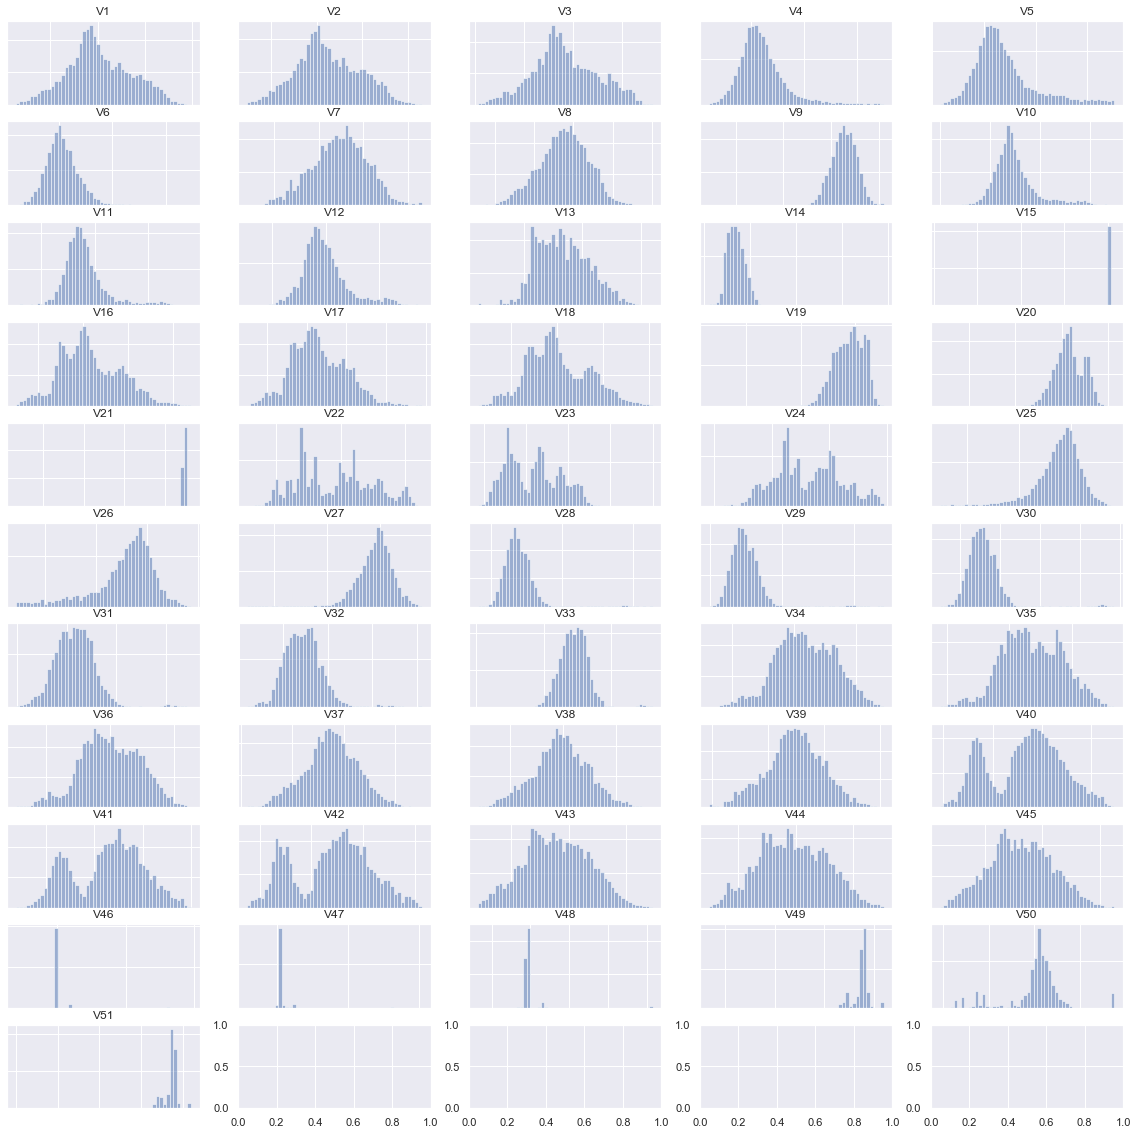

In [10]:
columns = df_test.iloc[:,0:].columns
fig, axes = plt.subplots(nrows=11, ncols=5,figsize=(20,20))
axes = axes.flatten()
for i in range(len(columns)):
    axes[i].hist(df_test[columns[i]], bins=50,facecolor='b',alpha=0.5)
    axes[i].set_title(columns[i])
    plt.setp(axes[i].get_xticklabels(), visible=False) 
    plt.setp(axes[i].get_yticklabels(), visible=False) 

In [11]:
def univariate_analysis_func(data, non_feature_cols):
    '''
    univariate_analysis_func is a function to analyze the data-prep variables univariately. This includes data description analysis, number of unique values analysis and data percentiles analysis.
    
    Parameters
    ----------
    data: The data that will be used in the models
    non_feature_cols: Targets dates or non features
    
    Output(s)
    ----------
    univariate_analysis_results: The final results of the univariate analysis
    '''
    
     #Keeping only features for this analysis
    data_feat = data.drop(non_feature_cols, axis=1)
    
    #Creating the DataFrame that contains the results
    univariate_analysis_results = pd.DataFrame()
    univariate_analysis_results['COLUMN NAME'] = data_feat.columns
    
    
    #Data Description Analysis
    data_description = data_description_func(data_feat)
    univariate_analysis_results = pd.merge(univariate_analysis_results,
                                           data_description,
                                           on='COLUMN NAME',
                                           how='left')
    
    #Data Percentiles Analysis
    percentiles = [0.01,0.05,0.95,0.99]
    data_percentiles = data_percentiles_func(data_feat, percentiles)
    univariate_analysis_results = pd.merge(univariate_analysis_results,
                                           data_percentiles,
                                           on='COLUMN NAME',
                                           how='left')

    #Number of Unique Values Analysis
    data_nunique_values = number_of_unique_values_func(data_feat)
    univariate_analysis_results = pd.merge(univariate_analysis_results,
                                           data_nunique_values,
                                           on='COLUMN NAME',
                                           how='left')

    return univariate_analysis_results

    
def data_description_func(data):
    '''
    data_description_func is a function to describe each column using the pandas describe function which includes count, mean, std, min, max, 25-50-75 percentiles.
    
    Parameters
    ----------
    data: The data that will be used in the models
    
    Output(s)
    ----------
    data_description: Results of pd.describe function
    '''
    #Finding the data description of the columns
    data_description = data.describe().T.reset_index()
    data_description = data_description.rename(columns={'index':'COLUMN NAME'})
    return data_description

def data_percentiles_func(data, percentiles):
    '''
    data_percentiles_func is a function to find the given percentiles of each numeric column
    
    Parameters
    ----------
    data: The data that will be used in the models
    percentiles: Percentiles to be found
    
    Output(s)
    ----------
    data_percentiles: Percentiles of each column
    '''
    #Finding the given percentiles of the columns
    data_percentiles = data.quantile(percentiles).T
    data_percentiles.columns = [str(int(i*100))+'%' for i in data_percentiles.columns]
    data_percentiles = data_percentiles.reset_index().rename(columns={'index':'COLUMN NAME'})
    
    return data_percentiles


def number_of_unique_values_func(data):
    '''
    number_of_unique_values_func is a function to find the number of unique values of each column
    
    Parameters
    ----------
    data: The data that will be used in the models
    
    Output(s)
    ----------
    data_nunique_values: Number of unique values of each column
    '''
    #Finding the number of unique values of the columns
    data_nunique_values = data.nunique().reset_index()
    data_nunique_values = data_nunique_values.rename(columns={'index':'COLUMN NAME',
                                                              0:'NUMBER OF UNIQUE VALUES'})
    
    return data_nunique_values



In [12]:
start = time.time()
writer_eval=pd.ExcelWriter('Univariate_Analysis.xlsx',engine='xlsxwriter')
univariate_analysis_results=univariate_analysis_func(df_train,non_feature_cols)
univariate_analysis_results.to_excel(writer_eval,index=False,sheet_name='univariate_analysis')
end = time.time()
print("time elapsed for univariate_analysis is {} seconds".format(end-start))
writer_eval.save()

time elapsed for univariate_analysis is 0.3740711212158203 seconds


## XGBOOST  WITHOUT ANY FEATURE ENGINEERING

In [66]:
#Model preparation and run without any feature engineering
x_cols=df_train.drop(non_feature_cols, axis=1).columns
X, y = df_train[x_cols], df_train['Target']
  
# Splitting
train_X, val_X, train_y, val_y = train_test_split(X, y, test_size = 0.25, random_state = 123,shuffle=True)
  
print("train_X size: {} - train_y size: {} ".format(train_X.shape,train_y.shape))
print("val_X size: {} - val_y size: {} ".format(val_X.shape,val_y.shape))

train_X size: (36717, 51) - train_y size: (36717,) 
val_X size: (12240, 51) - val_y size: (12240,) 


In [69]:
#XGBoost without parameter tuning
xgb_model = XGBRegressor(
        objective = 'reg:squarederror',
        colsample_bytree = 0.5,
        booster='gbtree',
        learning_rate = 0.1,
        random_state=42,
        max_depth = 5,
        min_child_weight = 1,
        n_estimators = 100,
        subsample = 0.5,
        reg_lambda=10)    
    
%time xgb_model.fit(train_X, train_y, early_stopping_rounds=5, eval_set=[(train_X, train_y),(val_X, val_y)], verbose=False)

y_pred_xgb = xgb_model.predict(val_X)

mse_xgb = MSE(val_y, y_pred_xgb)

print("RMSE: ", np.sqrt(mse_xgb))

r2=r2_score(y_pred_xgb, val_y, multioutput='variance_weighted')
print("Xgboost Accuracy score after feature enginnering: ", r2)

Wall time: 3.5 s
RMSE:  3.0467445264777093
Xgboost Accuracy score after feature enginnering:  0.7353734371098318


## FEATURE ENGINEERING

In [22]:
#Skewness Check
def skew_check(train_X,columns):
    for cols in train_X.columns:
        if abs(train_X[cols].skew())>1:
            print("Column: {} - skewness_value: {}".format(cols,train_X[cols].skew()))


In [23]:
skew_check(train_X,columns)

Column: V7 - skewness_value: -1.6895855053357418
Column: V8 - skewness_value: -1.7457002065552887
Column: V9 - skewness_value: -1.6104628465687525
Column: V10 - skewness_value: 2.64978809549435
Column: V11 - skewness_value: 2.8473583001416554
Column: V12 - skewness_value: 2.892425813473596
Column: V14 - skewness_value: 1.5738993960299086
Column: V15 - skewness_value: -2.0911139716999068
Column: V16 - skewness_value: 1.5487612716944115
Column: V17 - skewness_value: 1.4804232466562868
Column: V18 - skewness_value: 1.6066052154979156
Column: V20 - skewness_value: 1.6273574664715147
Column: V37 - skewness_value: -1.2787271701907232
Column: V38 - skewness_value: -1.266033221346961
Column: V39 - skewness_value: -1.326108186212233
Column: V47 - skewness_value: 4.476537163070532
Column: V48 - skewness_value: -5.295443718047264
Column: V49 - skewness_value: -10.955442279028833
Column: V50 - skewness_value: -11.357034506893655
Column: V51 - skewness_value: -10.590003261187373


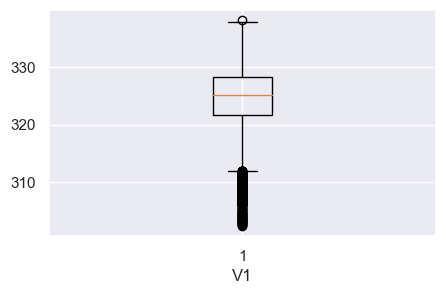

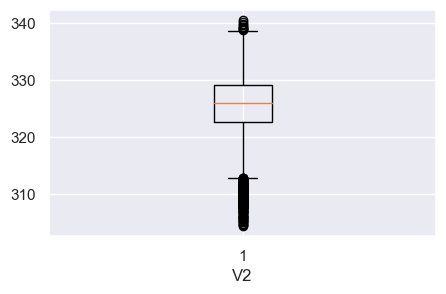

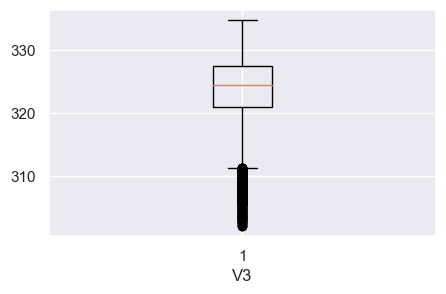

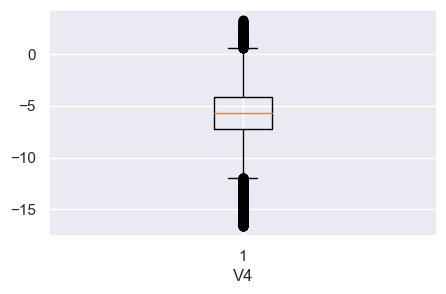

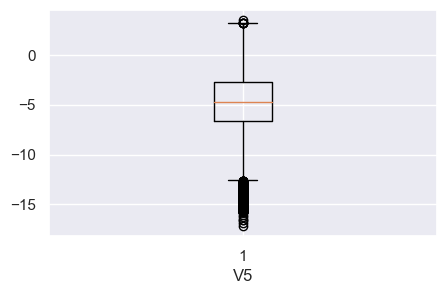

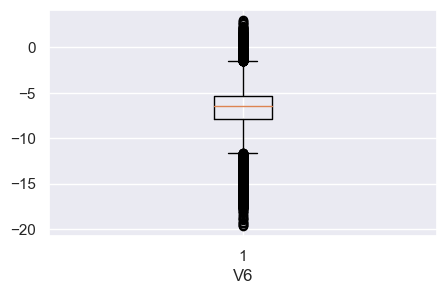

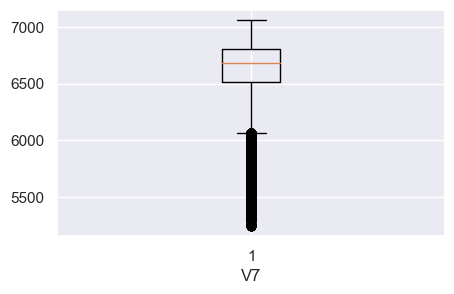

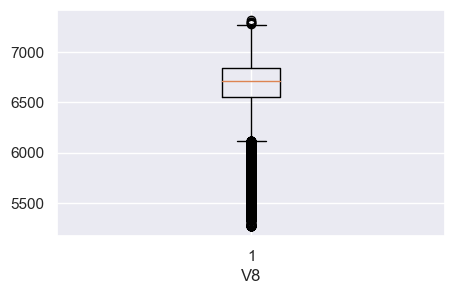

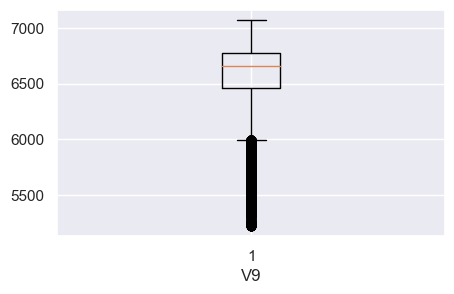

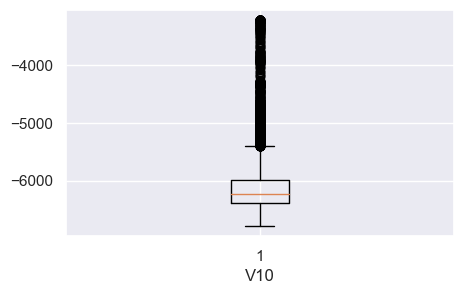

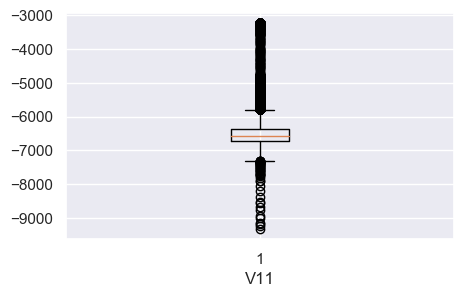

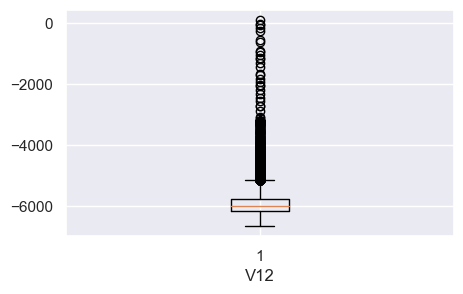

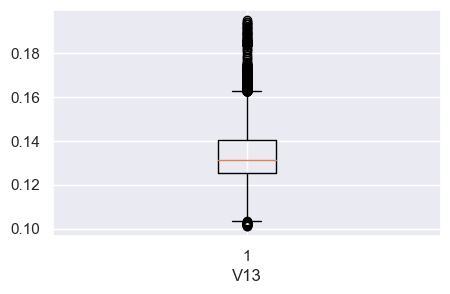

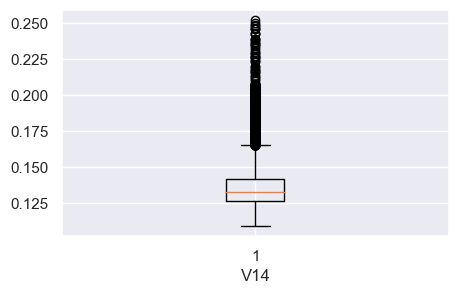

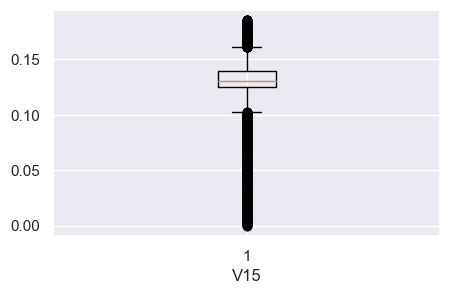

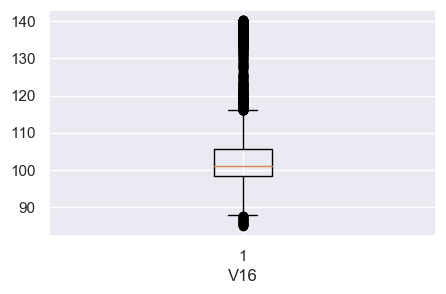

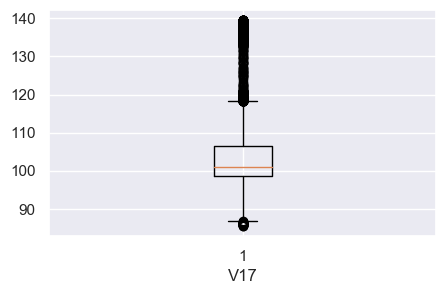

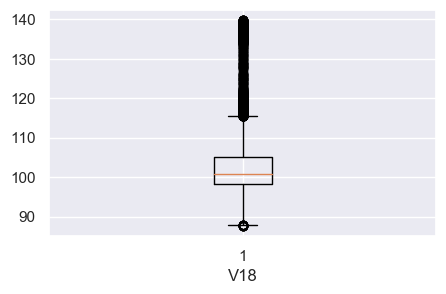

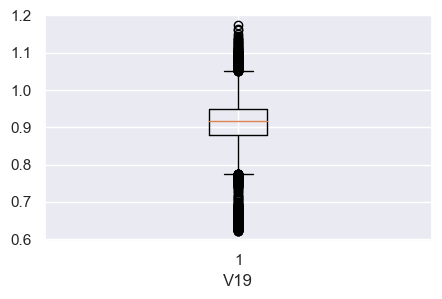

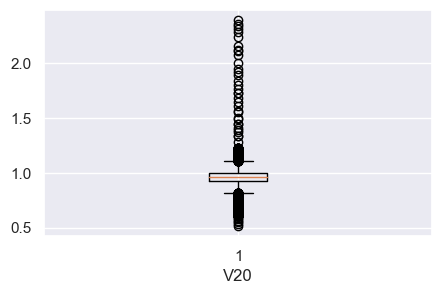

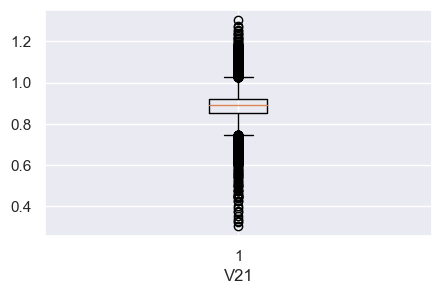

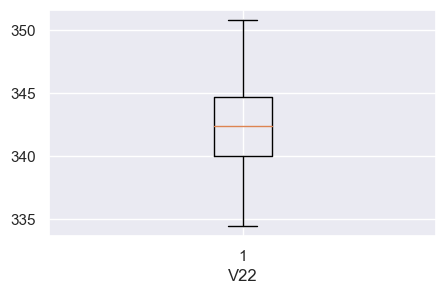

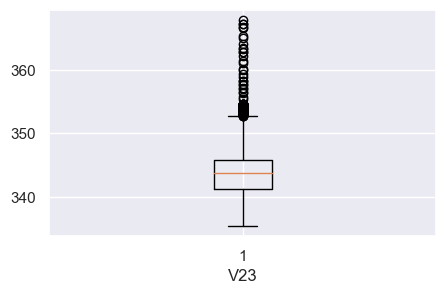

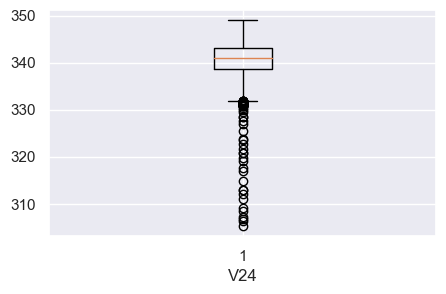

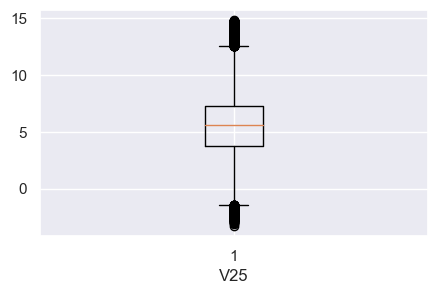

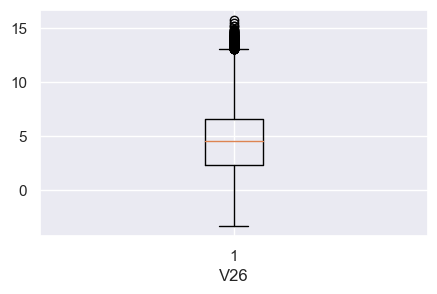

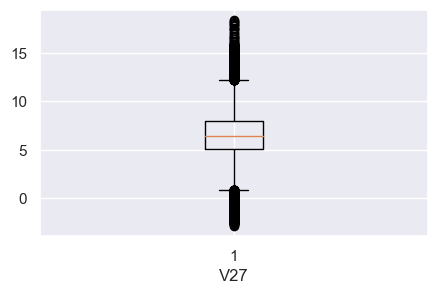

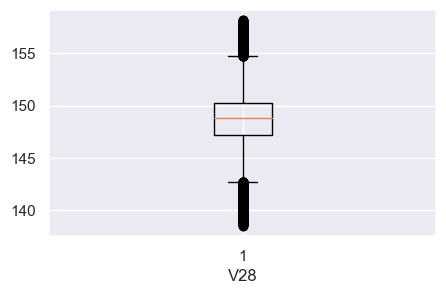

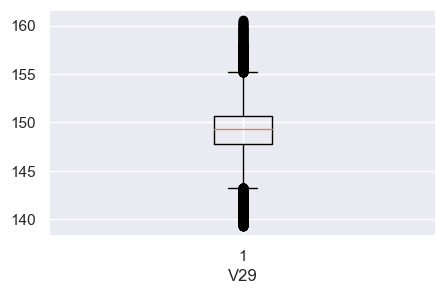

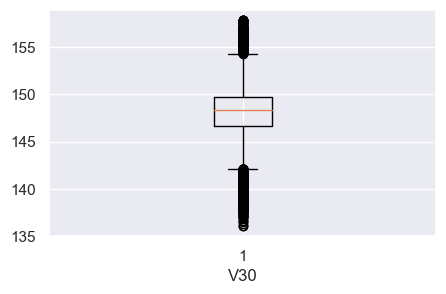

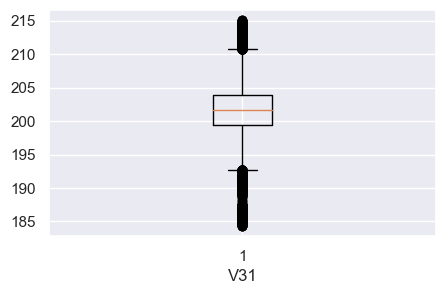

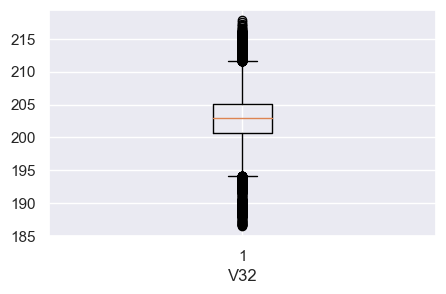

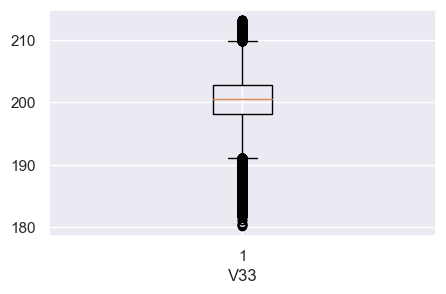

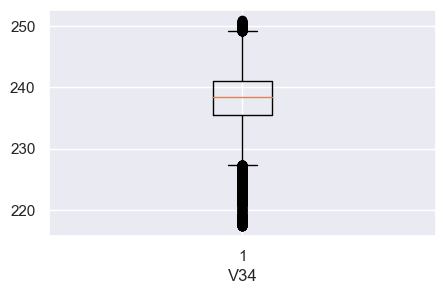

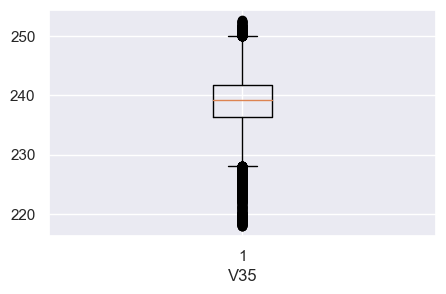

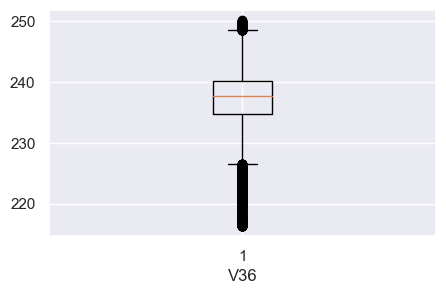

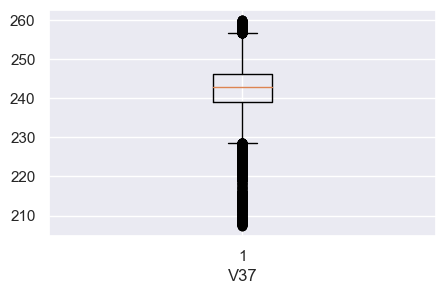

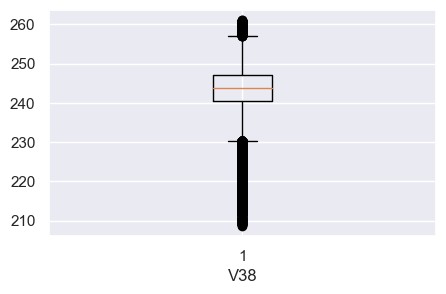

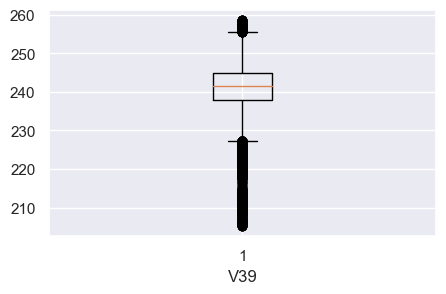

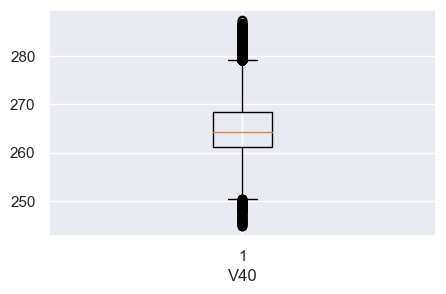

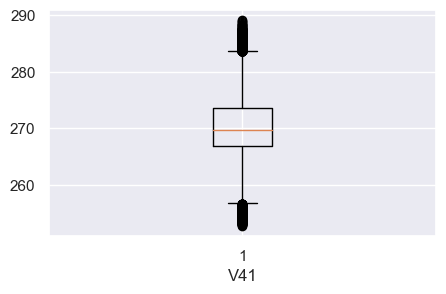

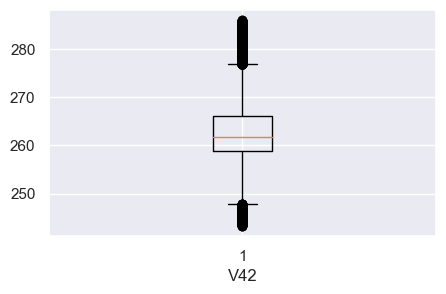

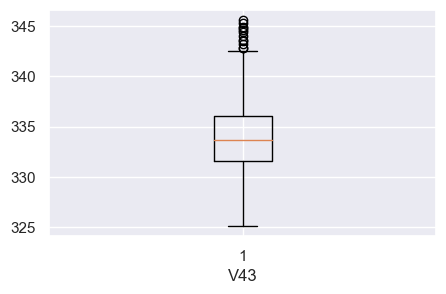

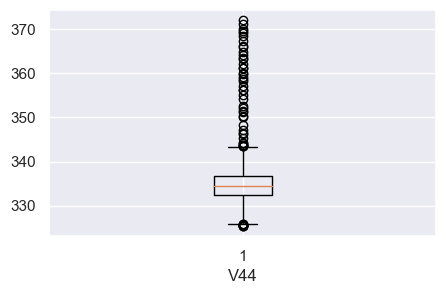

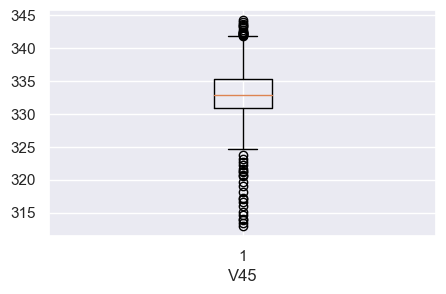

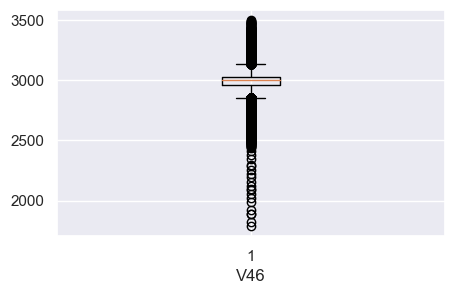

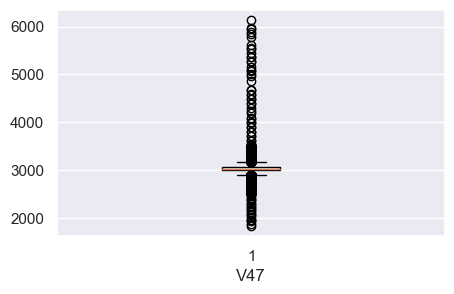

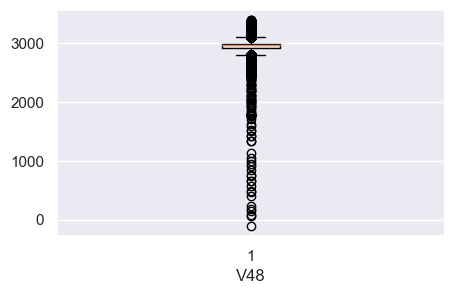

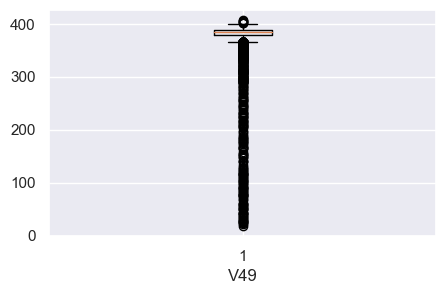

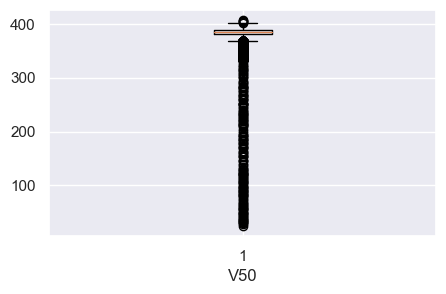

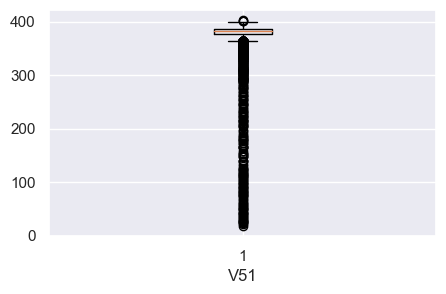

In [24]:
for c in train_X.columns:
    fig = plt.figure(figsize =(5, 3),dpi=100)
    plt.boxplot(train_X[c])
    plt.xlabel(c)
    plt.show()

In [30]:
train_x_outlier=train_X.copy()
for col in train_X.columns:
    percentiles = train_X[col].quantile([0.05, 0.95]).values
    train_x_outlier[col][train_X[col] <= percentiles[0]] = percentiles[0]
    train_x_outlier[col][train_X[col] >= percentiles[1]] = percentiles[1]

In [31]:
skew_check(train_x_outlier,columns)

Column: V7 - skewness_value: -1.2179972036563982
Column: V8 - skewness_value: -1.2674344235504262
Column: V9 - skewness_value: -1.2045428921753376
Column: V10 - skewness_value: 1.3315853365967922
Column: V11 - skewness_value: 1.311201549844213
Column: V12 - skewness_value: 1.208867481715923
Column: V49 - skewness_value: -1.2868739992215343
Column: V50 - skewness_value: -1.2597024627928037
Column: V51 - skewness_value: -1.3248492189852301


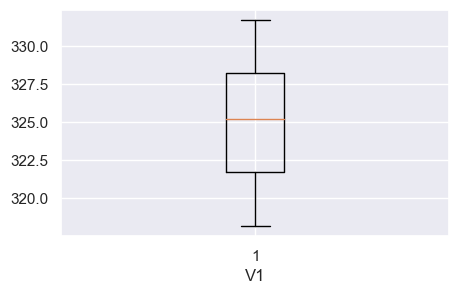

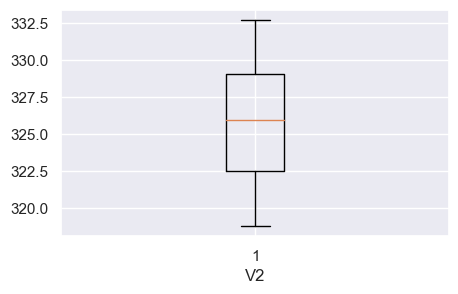

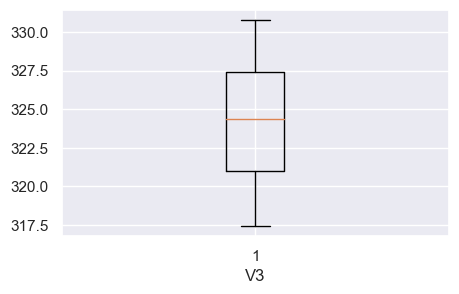

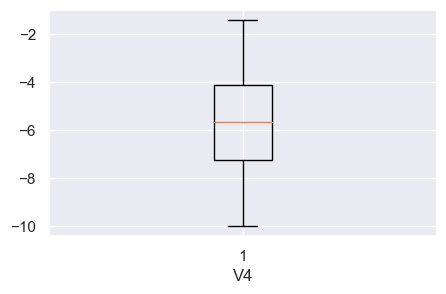

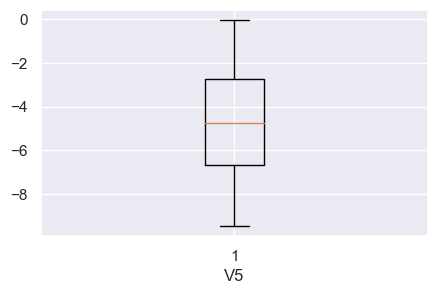

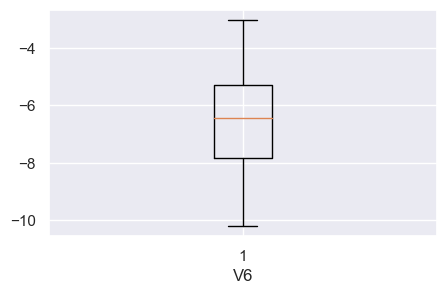

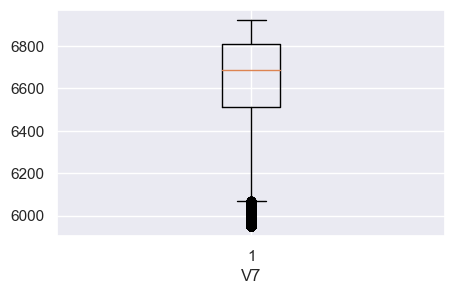

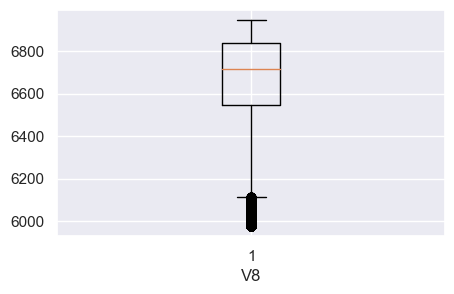

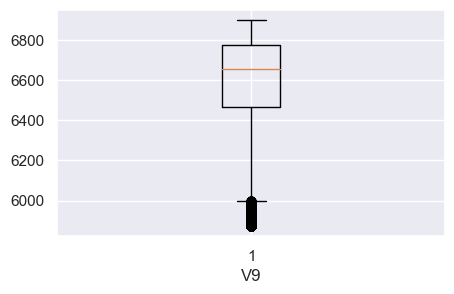

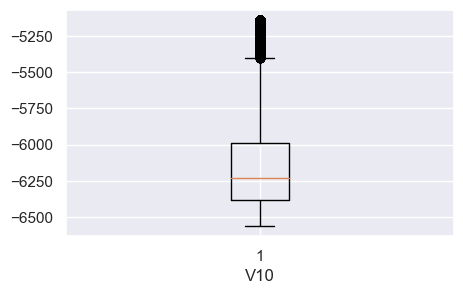

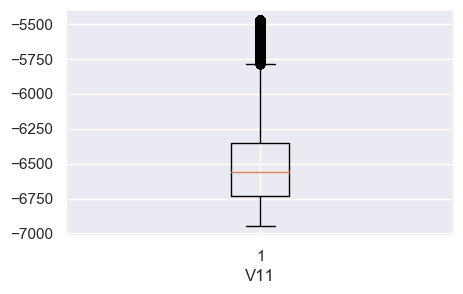

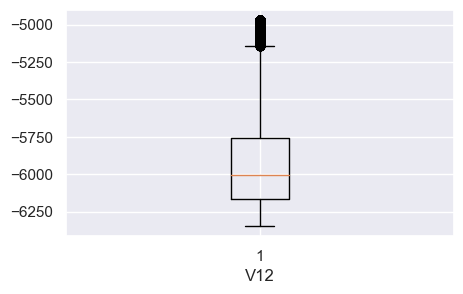

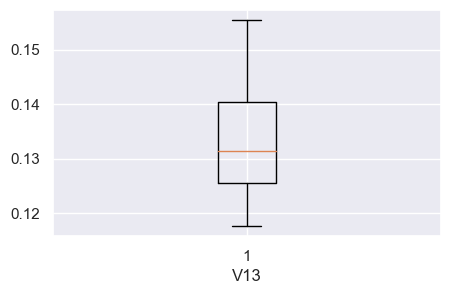

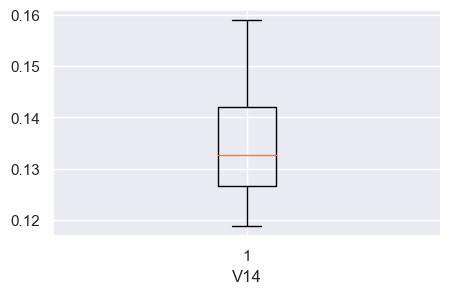

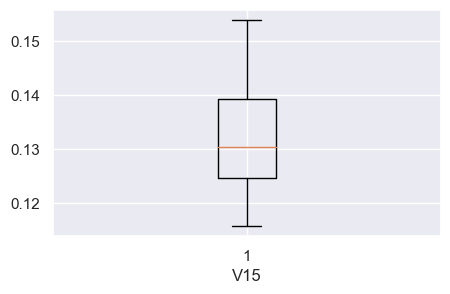

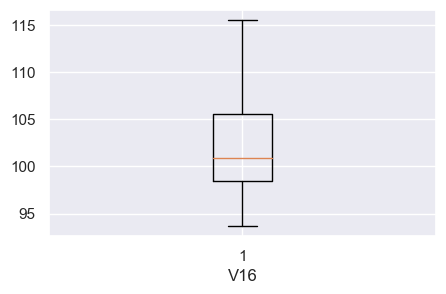

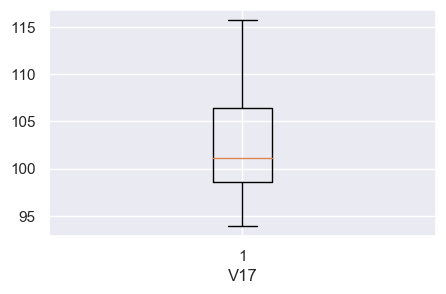

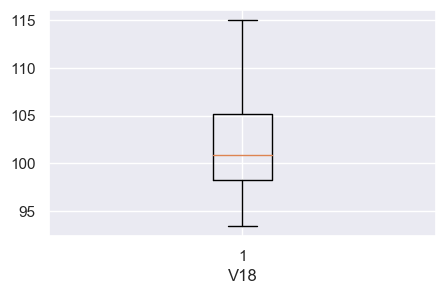

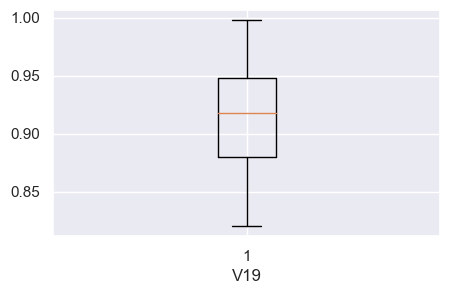

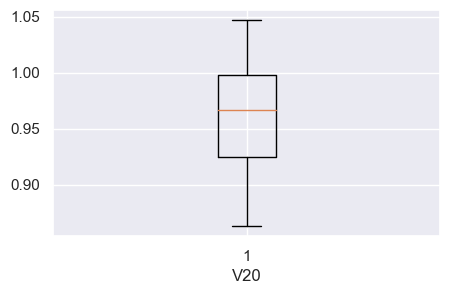

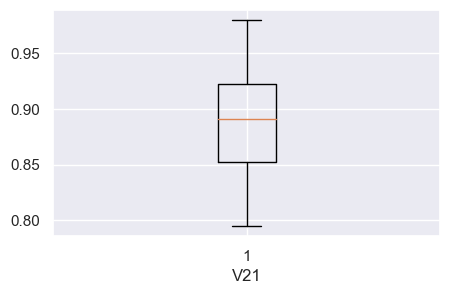

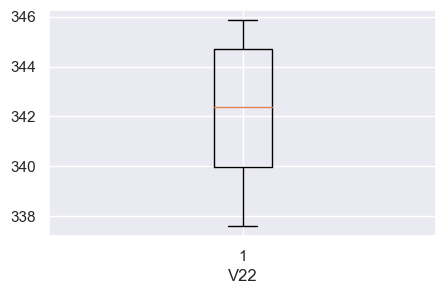

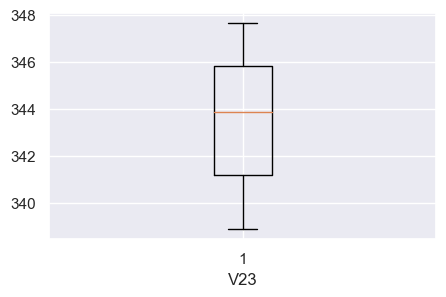

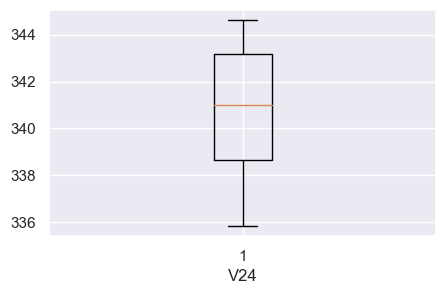

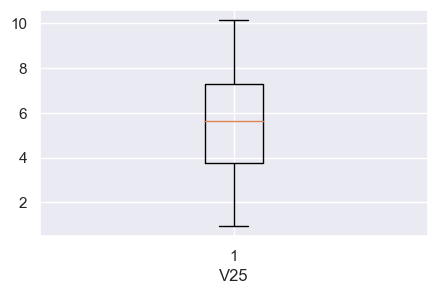

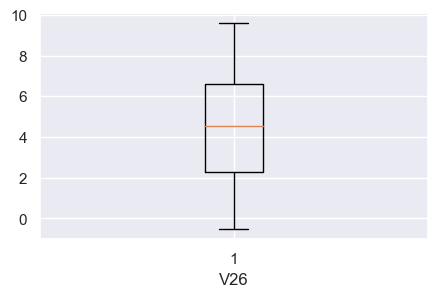

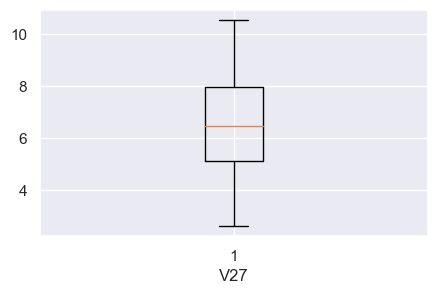

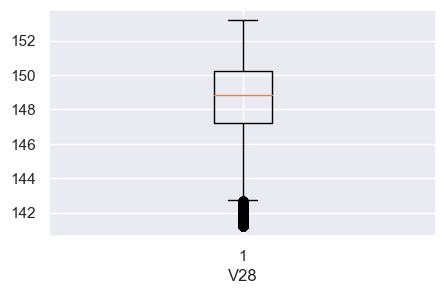

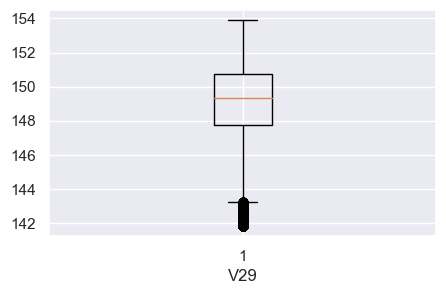

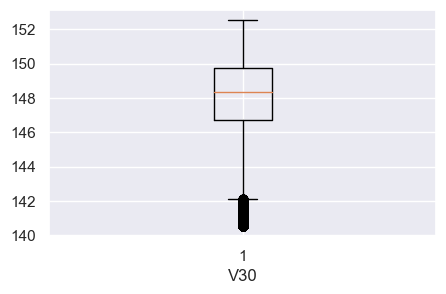

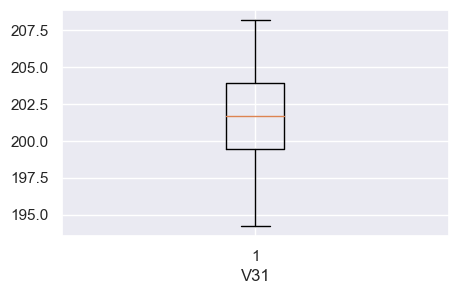

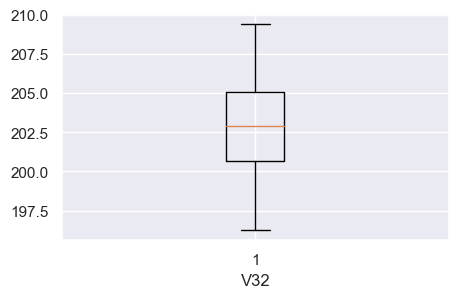

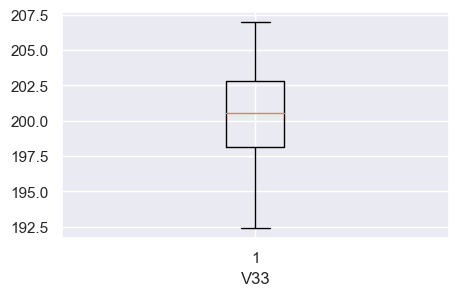

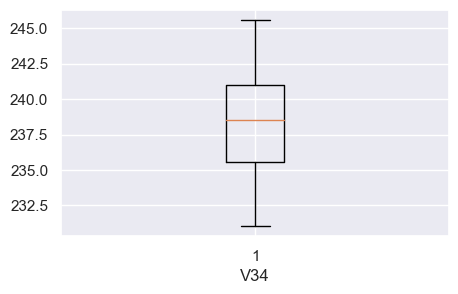

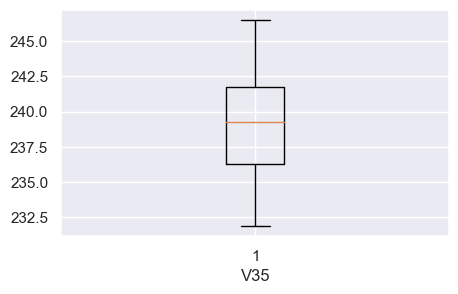

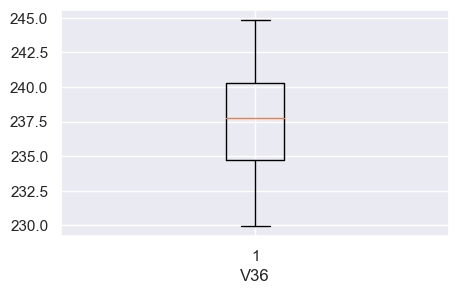

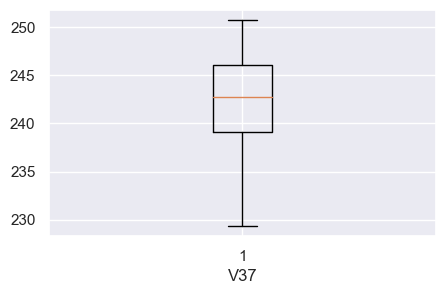

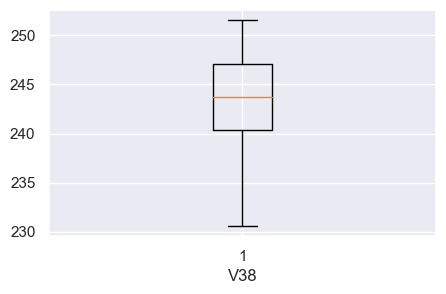

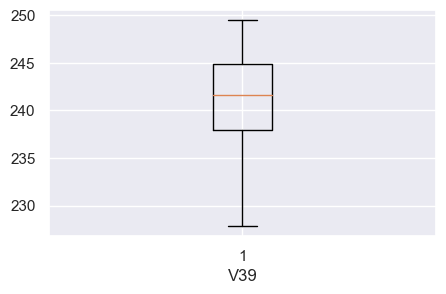

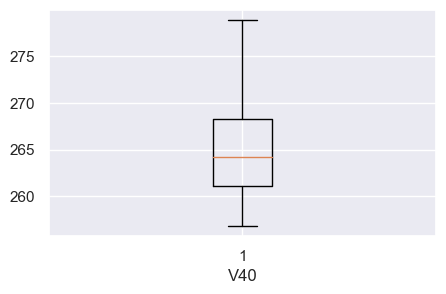

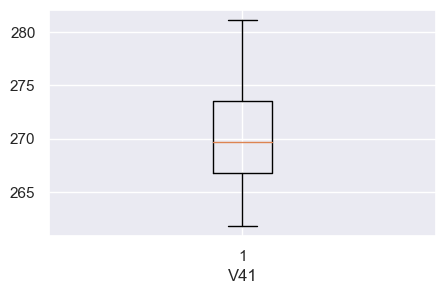

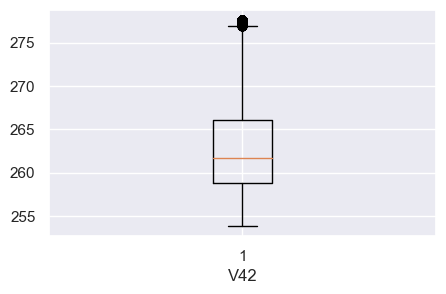

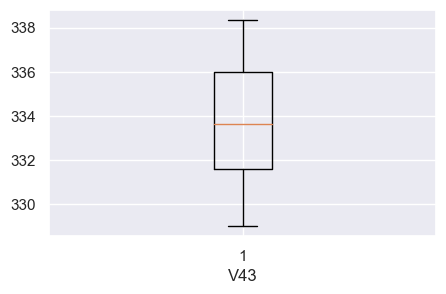

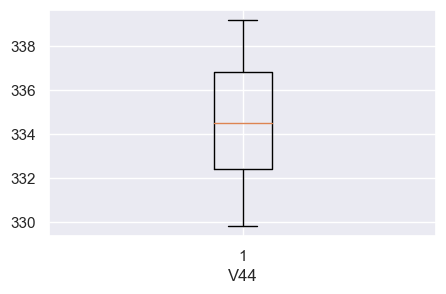

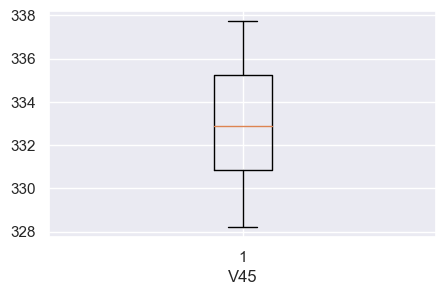

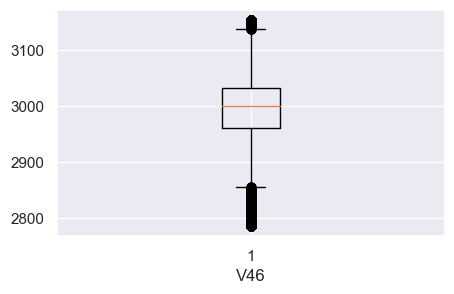

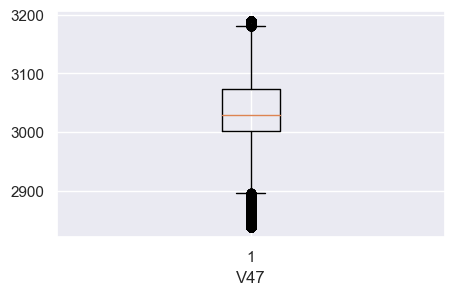

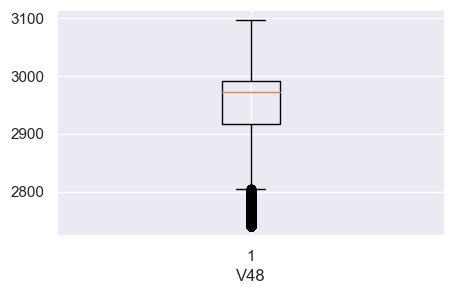

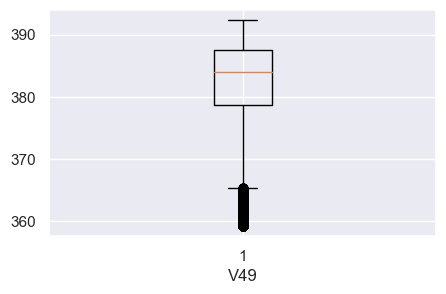

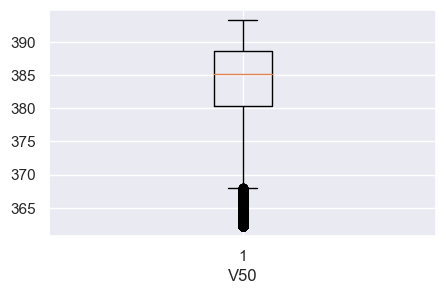

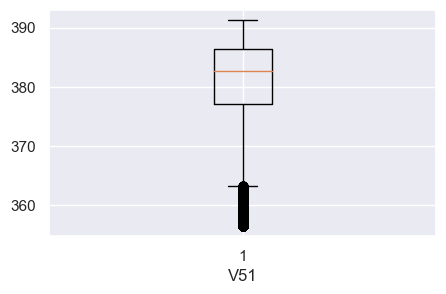

In [32]:
#Outlier Detection and Visualisation
for c in train_x_outlier.columns:
    fig = plt.figure(figsize =(5, 3),dpi=100)
    plt.boxplot(train_x_outlier[c])
    plt.xlabel(c)
    plt.show()

In [33]:
def tukey_func(df,column):
    q75, q25 = np.percentile(df[column], [75 ,25])
    IQR = q75 - q25
    threshold_values=pd.DataFrame(columns={'threshold','outliers_number'})
    for threshold in np.arange(1,4,0.5):
        min_value = q25 - (IQR*threshold)
        max_value = q75 + (IQR*threshold)
        outliers_number = len((np.where((df[column] > max_value)| (df[column]< min_value))[0]))
        threshold_values = threshold_values.append({'threshold': threshold,
                                                'outliers_number': outliers_number},ignore_index=True)
    return threshold_values

In [34]:
for c in train_x_outlier.columns:
    print("Column: {}".format(c))
    print(tukey_func(train_x_outlier,c))

Column: V1
   outliers_number  threshold
0              0.0        1.0
1              0.0        1.5
2              0.0        2.0
3              0.0        2.5
4              0.0        3.0
5              0.0        3.5
Column: V2
   outliers_number  threshold
0              0.0        1.0
1              0.0        1.5
2              0.0        2.0
3              0.0        2.5
4              0.0        3.0
5              0.0        3.5
Column: V3
   outliers_number  threshold
0              0.0        1.0
1              0.0        1.5
2              0.0        2.0
3              0.0        2.5
4              0.0        3.0
5              0.0        3.5
Column: V4
   outliers_number  threshold
0              0.0        1.0
1              0.0        1.5
2              0.0        2.0
3              0.0        2.5
4              0.0        3.0
5              0.0        3.5
Column: V5
   outliers_number  threshold
0              0.0        1.0
1              0.0        1.5
2              

5              0.0        3.5
Column: V38
   outliers_number  threshold
0           3112.0        1.0
1              0.0        1.5
2              0.0        2.0
3              0.0        2.5
4              0.0        3.0
5              0.0        3.5
Column: V39
   outliers_number  threshold
0           2958.0        1.0
1              0.0        1.5
2              0.0        2.0
3              0.0        2.5
4              0.0        3.0
5              0.0        3.5
Column: V40
   outliers_number  threshold
0           3391.0        1.0
1              0.0        1.5
2              0.0        2.0
3              0.0        2.5
4              0.0        3.0
5              0.0        3.5
Column: V41
   outliers_number  threshold
0           2241.0        1.0
1              0.0        1.5
2              0.0        2.0
3              0.0        2.5
4              0.0        3.0
5              0.0        3.5
Column: V42
   outliers_number  threshold
0           3622.0        1.0
1         

In [35]:
def correlation(data,columnsTitles, threshold):
    # Set of all names of correlated columns
    col_corr = []
    corr_mat = data.corr()
    corr_mat = corr_mat.reindex(columns=columnsTitles).reindex(columnsTitles)
    for i in range(len(corr_mat.columns)):
        for j in range(len(corr_mat.columns)):
            if (abs(corr_mat.iloc[i,j]) > threshold) and (abs(corr_mat.iloc[i,j]) != 1) and i<j and corr_mat.columns[i] not in col_corr:
                colname = corr_mat.columns[j]           
                col_corr.append(colname)
    return col_corr

In [36]:
col_corr=correlation(train_x_outlier,train_x_outlier.columns,0.9)      
col_corr

['V2',
 'V3',
 'V25',
 'V26',
 'V27',
 'V8',
 'V9',
 'V11',
 'V12',
 'V14',
 'V15',
 'V17',
 'V18',
 'V20',
 'V21',
 'V23',
 'V24',
 'V29',
 'V30',
 'V32',
 'V33',
 'V35',
 'V36',
 'V38',
 'V39',
 'V41',
 'V42',
 'V44',
 'V45',
 'V47',
 'V48',
 'V50',
 'V51']

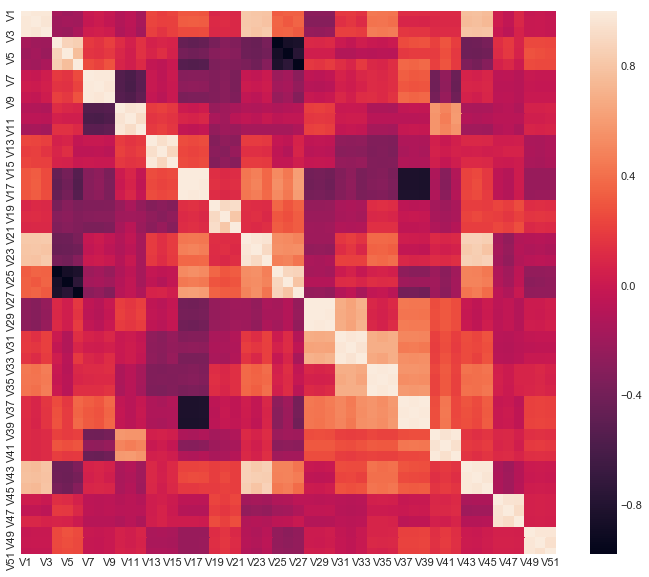

In [37]:
plt.style.use('seaborn-whitegrid')
plt.figure(figsize=(12, 10))
sns.heatmap(train_x_outlier.corr())
plt.show()

In [38]:
from statsmodels.tools.tools import add_constant
temp_X = add_constant(train_x_outlier)
temp_X= train_x_outlier.assign(const=1)
# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = temp_X.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(temp_X.values, i)
                          for i in range(len(temp_X.columns))]
  
print(vif_data.sort_values(by=['VIF'],ascending=False))

   feature           VIF
51   const  57576.327413
15     V16    462.401378
24     V25    405.602251
3       V4    369.582917
33     V34    358.835708
36     V37    347.161801
27     V28    327.322317
25     V26    288.486148
16     V17    271.943857
4       V5    269.211908
35     V36    252.399496
6       V7    245.902162
38     V39    235.292392
29     V30    225.422277
26     V27    224.247043
17     V18    219.786188
5       V6    196.473745
28     V29    190.113655
37     V38    183.175692
34     V35    177.950922
0       V1    128.817391
30     V31    125.186933
42     V43    122.240557
7       V8    110.565325
8       V9     99.878650
32     V33     94.550471
44     V45     88.267189
21     V22     80.165723
2       V3     80.047184
9      V10     79.278227
1       V2     77.058920
39     V40     72.583717
41     V42     69.254259
31     V32     65.449870
43     V44     64.227945
12     V13     61.420147
22     V23     40.517614
11     V12     40.496706
14     V15     33.851997


In [40]:
p_val=f_regression(train_x_outlier, train_y, center=True)[1]
p_val_x=[]
for i in range(len(p_val)):
    p_val_x.append([train_x_outlier.columns[i],p_val[i]])
p_val_x = pd.DataFrame(p_val_x, columns=["Features", "P_val"])
print(p_val_x.sort_values(by=['P_val'],ascending=False))    

   Features          P_val
12      V13   4.610826e-01
14      V15   1.030365e-01
34      V35   2.323851e-02
30      V31   1.170408e-02
32      V33   7.581775e-03
10      V11   7.389617e-04
13      V14   4.680939e-04
0        V1   2.733240e-06
44      V45   2.453523e-06
2        V3   1.866547e-06
33      V34   6.345842e-07
35      V36   4.963127e-10
42      V43   9.335732e-12
1        V2   6.363671e-16
31      V32   2.311689e-16
9       V10   4.494630e-17
28      V29   8.852757e-29
11      V12   3.563062e-29
43      V44   7.782269e-30
27      V28   5.417530e-36
47      V48   1.791557e-44
19      V20   4.564526e-45
29      V30   3.313660e-48
20      V21   2.809457e-64
18      V19   9.771089e-88
45      V46   5.023748e-93
23      V24   1.455087e-93
7        V8  3.563090e-119
21      V22  1.403017e-139
46      V47  1.875772e-141
6        V7  1.135540e-160
8        V9  6.982023e-191
22      V23  4.148855e-215
39      V40   0.000000e+00
48      V49   0.000000e+00
49      V50   0.000000e+00
4

In [84]:
corr = train_x_outlier.corr()
columns = np.full((corr.shape[0],), True, dtype=bool)
for i in range(corr.shape[0]):
    for j in range(i+1, corr.shape[0]):
        if corr.iloc[i,j] >= 0.9:
            if columns[j]:
                columns[j] = False
selected_columns = train_x_outlier.columns[columns]
corr_clean_X = train_x_outlier[selected_columns]
print(corr_clean_X.columns)
print("Column left: {}".format(len(corr_clean_X.columns)))

Index(['V1', 'V4', 'V5', 'V6', 'V7', 'V10', 'V13', 'V16', 'V19', 'V22', 'V25',
       'V26', 'V27', 'V28', 'V31', 'V34', 'V37', 'V40', 'V43', 'V46', 'V49'],
      dtype='object')
Column left: 21


In [50]:
target_corr = abs(df_train.corr())
target_corr['Target'].sort_values(ascending=False)

Target    1.000000
V25       0.447078
V26       0.446578
V5        0.437821
V4        0.432077
V27       0.404815
V6        0.380601
V41       0.261196
V17       0.230793
V39       0.225655
V16       0.224563
V37       0.220852
V18       0.219073
V38       0.218491
V40       0.216132
V42       0.213435
V23       0.161213
V9        0.157623
V7        0.148857
V22       0.132667
V8        0.129759
V46       0.105181
V24       0.101253
V51       0.087378
V48       0.086922
V49       0.086474
V50       0.084184
V47       0.082464
V21       0.070801
V19       0.070571
V36       0.066494
V30       0.063972
V34       0.061777
V44       0.057092
V28       0.054463
V29       0.045556
V35       0.043804
V20       0.041230
V3        0.039811
V1        0.038725
V43       0.031172
V14       0.029253
V32       0.027194
V33       0.026951
V11       0.023454
V12       0.022167
V15       0.021550
V2        0.021325
V45       0.019987
V10       0.005449
V13       0.004143
V31       0.000312
Name: Target

In [86]:
# Brute Force Method to find Correlation between features
def correlation(data, threshold=None):
    # Set of all names of correlated columns
    col_corr = set()
    corr_mat = data.corr()
    for i in range(len(corr_mat.columns)):
        for j in range(i):
            if (abs(corr_mat.iloc[i,j]) > threshold):
                colname = corr_mat.columns[i]
                col_corr.add(colname)
    return col_corr

In [87]:
correlated_features = correlation(data=train_x_outlier, threshold=0.9)
len(set(correlated_features))

33

In [89]:
# Build a Dataframe with Correlation between Features
corr_matrix = train_x_outlier.corr()
# Take absolute values of correlated coefficients
corr_matrix = corr_matrix.abs().unstack()
corr_matrix = corr_matrix.sort_values(ascending=False)
# Take only features with correlation above threshold of 0.8
corr_matrix = corr_matrix[corr_matrix >= 0.9]
corr_matrix = corr_matrix[corr_matrix < 1]
corr_matrix = pd.DataFrame(corr_matrix).reset_index()
corr_matrix.columns = ['feature1', 'feature2', 'Correlation']
corr_matrix

,feature1,feature2,Correlation
0,V18,V16,0.995221
1,V16,V18,0.995221
2,V16,V17,0.995219
3,V17,V16,0.995219
4,V28,V30,0.995212
...,...,...,...
87,V11,V12,0.916061
88,V19,V20,0.904236
89,V20,V19,0.904236
90,V23,V24,0.903171


In [91]:
# Get groups of features that are correlated amongs themselves
grouped_features = []
correlated_groups = []

for feature in corr_matrix.feature1.unique():
    if feature not in grouped_features:
        # Find all features correlated to a single feature
        correlated_block = corr_matrix[corr_matrix.feature1 == feature]
        grouped_features = grouped_features + list(correlated_block.feature2.unique()) + [feature]
        
        # Append block of features to the list
        correlated_groups.append(correlated_block)

print('Found {} correlated feature groups'.format(len(correlated_groups)))
print('out of {} total features.'.format(train_x_outlier.shape[1]))

Found 18 correlated feature groups
out of 51 total features.


In [92]:
# Visualize Correlated Feature Groups
for group in correlated_groups:
    print(group)
    print('\n')

   feature1 feature2  Correlation
0       V18      V16     0.995221
16      V18      V17     0.990959


  feature1 feature2  Correlation
4      V28      V30     0.995212
6      V28      V29     0.994073


   feature1 feature2  Correlation
8       V39      V37     0.993779
21      V39      V38     0.990494


   feature1 feature2  Correlation
10      V36      V34     0.992857
31      V36      V35     0.982897


   feature1 feature2  Correlation
14       V8       V7     0.991447
50       V8       V9     0.974803


   feature1 feature2  Correlation
26      V42      V40     0.988122
79      V42      V41     0.943030


   feature1 feature2  Correlation
28      V33      V31     0.984920
71      V33      V32     0.955796


   feature1 feature2  Correlation
32      V43      V45     0.981771
43      V43      V44     0.977732


   feature1 feature2  Correlation
34       V5      V26     0.981163


   feature1 feature2  Correlation
36       V2       V1     0.978897
63       V2       V3     0.965527

In [102]:
correlated_groups 

[   feature1 feature2  Correlation
 0       V18      V16     0.995221
 16      V18      V17     0.990959,   feature1 feature2  Correlation
 4      V28      V30     0.995212
 6      V28      V29     0.994073,    feature1 feature2  Correlation
 8       V39      V37     0.993779
 21      V39      V38     0.990494,    feature1 feature2  Correlation
 10      V36      V34     0.992857
 31      V36      V35     0.982897,    feature1 feature2  Correlation
 14       V8       V7     0.991447
 50       V8       V9     0.974803,    feature1 feature2  Correlation
 26      V42      V40     0.988122
 79      V42      V41     0.943030,    feature1 feature2  Correlation
 28      V33      V31     0.984920
 71      V33      V32     0.955796,    feature1 feature2  Correlation
 32      V43      V45     0.981771
 43      V43      V44     0.977732,    feature1 feature2  Correlation
 34       V5      V26     0.981163,    feature1 feature2  Correlation
 36       V2       V1     0.978897
 63       V2       V3  

In [103]:
train_x_outlier_3=train_x_outlier.drop(['V18','V28','V39','V36','V8','V42','V33','V43','V5','V2','V13','V25','V12','V22','V49','V6','V46','V19'],axis=1)

In [119]:
corr_clean_X=train_x_outlier_3.copy()

In [120]:
temp_X = add_constant(corr_clean_X)
temp_X= corr_clean_X.assign(const=1)
# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = temp_X.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(temp_X.values, i)
                          for i in range(len(temp_X.columns))]

print(vif_data.sort_values(by=['VIF'],ascending=False))

   feature           VIF
33   const  51372.308126
9      V16    189.353683
10     V17    179.904635
23     V37    155.901883
21     V34    136.695223
24     V38    129.672379
22     V35    127.056229
18     V30    106.272420
17     V29    102.310193
3       V7     90.426988
4       V9     89.145614
19     V31     62.565771
0       V1     57.554070
20     V32     57.262799
1       V3     52.316652
28     V45     41.614922
27     V44     38.728937
26     V41     27.048435
25     V40     26.367883
6      V11     24.731968
5      V10     24.058709
14     V24     16.131311
13     V23     15.780674
2       V4     11.647003
31     V50     10.074221
32     V51      9.900459
7      V14      9.504421
8      V15      8.867037
29     V47      8.768092
30     V48      8.665287
16     V27      7.914676
15     V26      7.166870
11     V20      6.296572
12     V21      5.674216


# Model Selection and Hyperparameter Tuning

In [121]:
selected_cols=corr_clean_X.columns

In [122]:
#XGBoost hyper-parameter tuning
def hyperParameterTuning(train_X, train_y):
    param_tuning = {
        'learning_rate': [0.1,0.2],
        'max_depth': [7,10],
        'min_child_weight': [1, 3],
        'subsample': [0.5],
        'colsample_bytree': [0.5],
        'n_estimators' : [100],
        'booster':['gbtree'],
        'reg_lambda' : [10],
        'objective': ['reg:squarederror']
    }
    
    
    xgb_model = XGBRegressor()
    gsearch = GridSearchCV(estimator = xgb_model,
                           param_grid = param_tuning,                        
                           #scoring = 'neg_mean_absolute_error', #MAE
                           scoring = 'neg_mean_squared_error',  #MSE
                           cv = 10,
                           verbose = 1)

    gsearch.fit(train_X,train_y)

    return gsearch.best_params_

In [123]:
hyperParameterTuning(corr_clean_X, train_y)

Fitting 10 folds for each of 8 candidates, totalling 80 fits


{'booster': 'gbtree',
 'colsample_bytree': 0.5,
 'learning_rate': 0.2,
 'max_depth': 10,
 'min_child_weight': 1,
 'n_estimators': 100,
 'objective': 'reg:squarederror',
 'reg_lambda': 10,
 'subsample': 0.5}

In [124]:
lambda_values = [1,10]
for val in lambda_values:    
    xgb_model = XGBRegressor(
            objective = 'reg:squarederror',
            colsample_bytree = 0.5,
            learning_rate = 0.2,
            max_depth =5,
            min_child_weight = 1,
            n_estimators = 100,
            subsample = 0.5,
            booster='gbtree',
            reg_lambda=val)

    xgb_model.fit(corr_clean_X, train_y, early_stopping_rounds=5, eval_set=[(corr_clean_X, train_y),(val_X[selected_cols], val_y)], verbose=False)

    y_pred_xgb = xgb_model.predict(val_X[selected_cols])

    mse_xgb = MSE(val_y, y_pred_xgb)
    print("lambda = ", val)
    print("RMSE: ", np.sqrt(mse_xgb))
    r2=r2_score(y_pred_xgb, val_y, multioutput='variance_weighted')
    print("Xgboost Accuracy score after feature enginnering: ", r2)

lambda =  1
RMSE:  1.9758223950337632
Xgboost Accuracy score after feature enginnering:  0.916895720737661
lambda =  10
RMSE:  1.965148887696538
Xgboost Accuracy score after feature enginnering:  0.9173435074160626


In [135]:
accuracy = cross_val_score(xgb_model, val_X[selected_cols], val_y, cv = 10)
print(accuracy)
#get the mean of each fold 
print("Accuracy of Model with Cross Validation is:",accuracy.mean())

[0.8633765  0.82802226 0.8145477  0.77671952 0.7898374  0.85174307
 0.70648041 0.89773598 0.88932885 0.86632502]
Accuracy of Model with Cross Validation is: 0.8284116713369082


In [147]:
sorted_idx = np.argsort(xgb_model.feature_importances_)[::-1]
for index in sorted_idx:
    print([val_X.columns[index], xgb_model.feature_importances_[index]]) 

['V3', 0.07028984]
['V10', 0.055977352]
['V29', 0.051198203]
['V25', 0.049416076]
['V23', 0.046297666]
['V11', 0.0453005]
['V16', 0.044426054]
['V33', 0.0419095]
['V17', 0.040263146]
['V18', 0.038939994]
['V22', 0.038040783]
['V15', 0.036706436]
['V2', 0.0366612]
['V30', 0.034200035]
['V1', 0.029532611]
['V32', 0.028528096]
['V28', 0.027721647]
['V20', 0.027027966]
['V9', 0.027006593]
['V4', 0.026544115]
['V21', 0.025839591]
['V19', 0.024332223]
['V26', 0.021222414]
['V8', 0.01908845]
['V5', 0.015448967]
['V6', 0.015169291]
['V13', 0.014559364]
['V27', 0.0137298945]
['V31', 0.01250863]
['V14', 0.012053007]
['V12', 0.011172921]
['V7', 0.010410263]
['V24', 0.008477121]


In [126]:
df_std_test=df_test.copy()

In [127]:
y_pred_test = xgb_model.predict(df_std_test[selected_cols])
y_pred_test

array([412.49216, 410.23407, 410.39258, ..., 411.6647 , 411.91098,
       414.76422], dtype=float32)

In [128]:
df_test['Target'] = y_pred_test

df_test_result = pd.merge(df_test,df_test[['Target']],how = 'left')

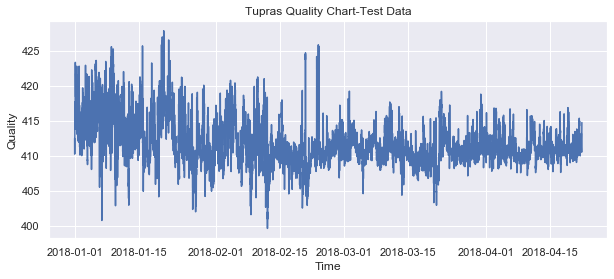

In [129]:
sns.set()
plt.figure(figsize=(10, 4))
plt.title("Tupras Quality Chart-Test Data")
plt.xlabel("Time")
plt.ylabel("Quality")
plt.plot(df_test["Target"])
plt.show()

In [154]:
df_test["Target"].describe()

count    10657.000000
mean       411.780060
std          3.169440
min        399.587463
25%        409.825928
50%        411.066986
75%        413.267761
max        427.918121
Name: Target, dtype: float64

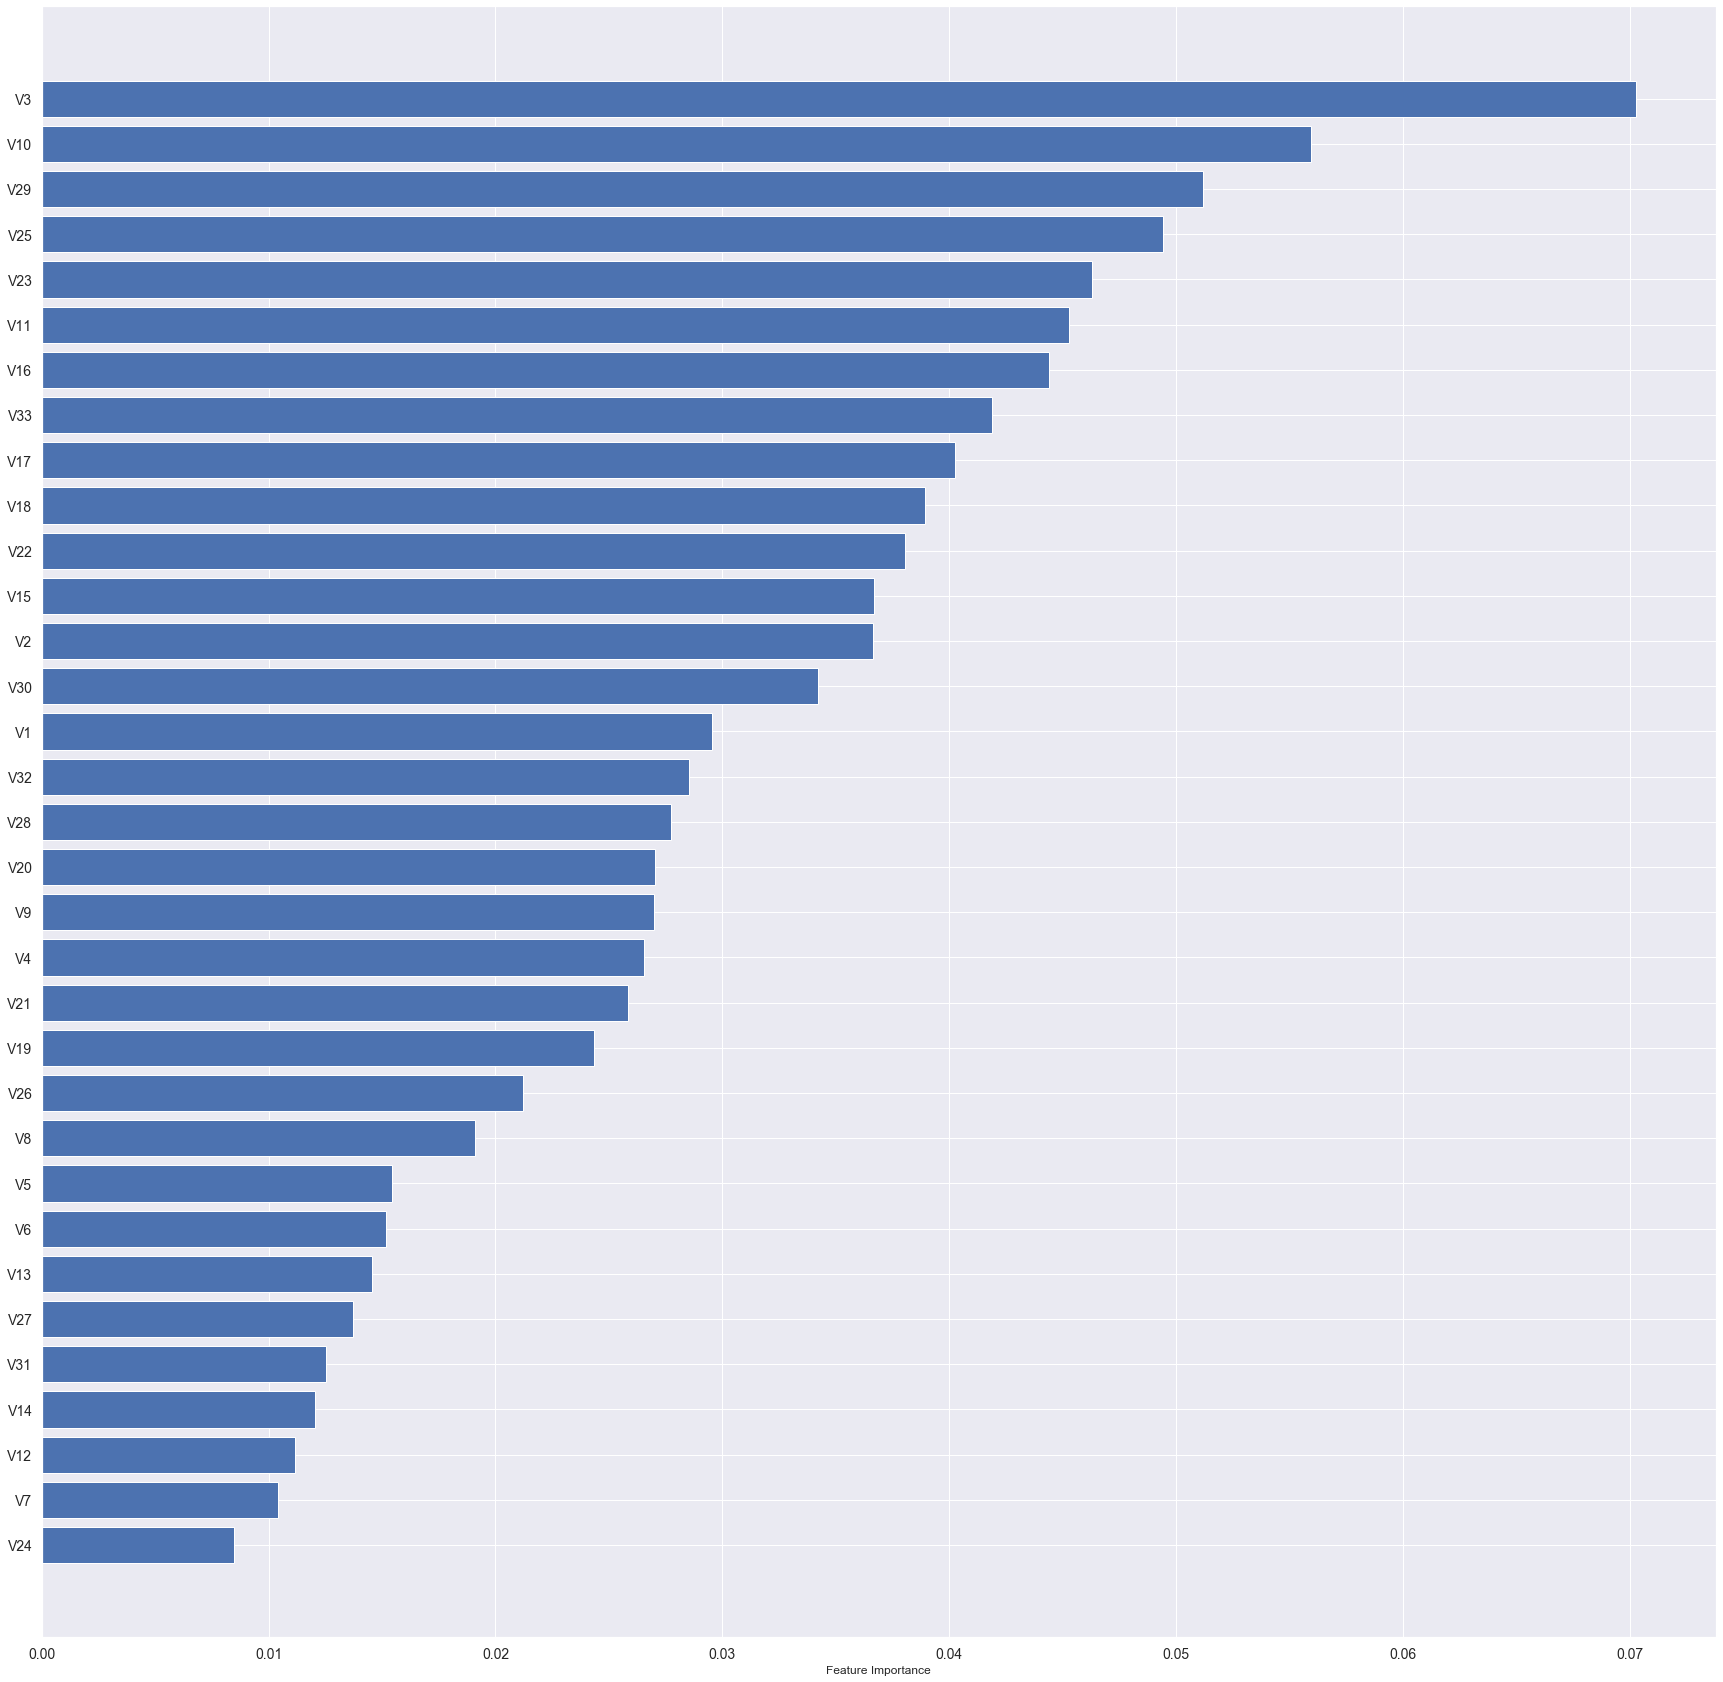

In [143]:
plt.figure(figsize=(30, 30))
sorted_feat = xgb_model.feature_importances_.argsort()
plt.barh(val_X.columns[sorted_feat], xgb_model.feature_importances_[sorted_feat])
plt.xlabel("Feature Importance")
plt.tick_params(labelsize=14)

In [152]:
shap_values = shap.TreeExplainer(xgb_model).shap_values(df_train[selected_cols])

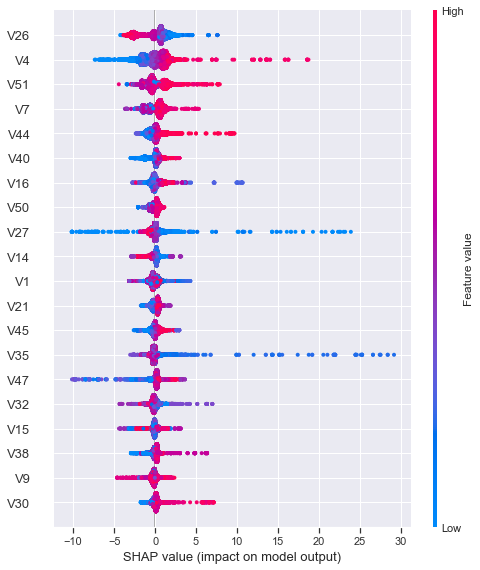

In [153]:
shap.summary_plot(shap_values,df_train[selected_cols])

In [134]:
writer_eval=pd.ExcelWriter('Test_results.xlsx',engine='xlsxwriter')
df_test_result.to_excel(writer_eval,index=False,sheet_name='Test_Results')
writer_eval.save()